# Analyse the discharge prediction

We first load results from "*test_results.pickle*", outputed by the training procedure. Then, we can visualize the results, e.g., rainfall and discharge (Sim vs. Obs)


In [1]:
# Import necessary packages
import pickle
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

sys.path.append("..")
from hy2dl.aux_functions.functions_evaluation import nse
from hy2dl.aux_functions.utils import create_folder
# from hy2dl.datasetzoo.hourlycamelsde import HourlyCAMELS_DE as Datasetclass
# from hy2dl.modelzoo.mflstm import MFLSTM as modelclass

In [2]:
# Load the test_results from a pickle file
file_path = r"D:\Research\Projects\Hy2DL\results\Edu_14_day_seed_110\test_results\test_results.pickle"

# Path to save the excel file with rainfall and discharge values
test_result_save_path = r"D:\Research\Projects\Hy2DL\results\Edu_14_day_seed_110\test_results"

create_folder(folder_path=test_result_save_path)

# Load the test results
with open(file_path, "rb") as f:
    test_results = pickle.load(f)

Folder 'D:\Research\Projects\Hy2DL\results\Edu_14_day_seed_110\test_results' already exists.


## 1. Calculate the metrics (Optional)

In [3]:
# Loss testing
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={"basin_id": test_results.keys(), "NSE": np.round(loss_testing, 3)})
df_NSE = df_NSE.set_index("basin_id")

# Save the NSE for each basin in a csv file
df_NSE.to_csv(os.path.join(test_result_save_path, "NSE_testing.csv"), index=True, header=True)
median_nse = df_NSE["NSE"].median()
mean_nse = df_NSE["NSE"].mean()
print(f"Median NSE across all basins: {median_nse:.3f}")
print(f"Mean NSE across all basins: {mean_nse:.3f}")

Median NSE across all basins: 0.651
Mean NSE across all basins: 0.536


## 2. Draw graph and save results in Excel files (For one basin)

In [10]:
# Select one basin for analysis
# basin_to_analyze = "01022500" # US\
basin_to_analyze = "DE213740"  # the biggest basin
# basin_to_analyze = "DE211270" # the smallest basin

# Load the test results
with open(file_path, "rb") as f:
    test_results = pickle.load(f)

# View the first few rows of the DataFrame for one basin
print(f"The first rows of the basin {basin_to_analyze}: \n {test_results[basin_to_analyze].head()}")

The first rows of the basin DE213740: 
                        y_obs     y_sim
2019-01-01 01:00:00  0.02343  0.026015
2019-01-01 02:00:00  0.02304  0.025968
2019-01-01 03:00:00  0.02211  0.025904
2019-01-01 04:00:00  0.02130  0.025845
2019-01-01 05:00:00  0.02107  0.025787


### 2.1 Extract rainfall data from the csv file

Note: We need to select one CAMELS dataset for load rainfall data

In [5]:
# # # CAMERS_US dataset
# csv_file_path = f"/hkfs/home/haicore/iwu/qa8171/Project/Hy2DL/data/CAMELS_US/hourly/nldas_hourly/{basin_to_analyze}_hourly_nldas.csv"
# time_label = ["date"]
# target_variables = ["total_precipitation"]

# CAMERS_DE dataset
csv_file_path = f"D:\Research\Projects\Hy2DL\data\CAMELS_DE\hourly\CAMELS_DE_1h_hydromet_timeseries_{basin_to_analyze}.csv"
time_label = ["time"]
target_variables = ["precipitation_sum_mean"]

df = pd.read_csv(csv_file_path, parse_dates=time_label)

# get time window from test_results.pickle
start_time = test_results[basin_to_analyze]["y_obs"].index[0]
end_time = test_results[basin_to_analyze]["y_obs"].index[-1]
start_time = pd.to_datetime(start_time)
end_time = pd.to_datetime(end_time)

# search for target_variables
filtered_df = df[(df[time_label[0]] >= start_time) & (df[time_label[0]] <= end_time)]

# extract target_variables with time
rainfall_df = filtered_df[[time_label[0]] + target_variables]
print(rainfall_df)

                      time  precipitation_sum_mean
157776 2019-01-01 01:00:00                     0.0
157777 2019-01-01 02:00:00                     0.0
157778 2019-01-01 03:00:00                     0.0
157779 2019-01-01 04:00:00                     0.0
157780 2019-01-01 05:00:00                     0.0
...                    ...                     ...
201571 2023-12-30 20:00:00                     0.0
201572 2023-12-30 21:00:00                     0.0
201573 2023-12-30 22:00:00                     0.0
201574 2023-12-30 23:00:00                     0.0
201575 2023-12-31 00:00:00                     0.0

[43800 rows x 2 columns]


### 2.2 Draw discharge graph (Sim vs. Obs)

We can select to show (1) the whole test time period, or (2) a custom time period

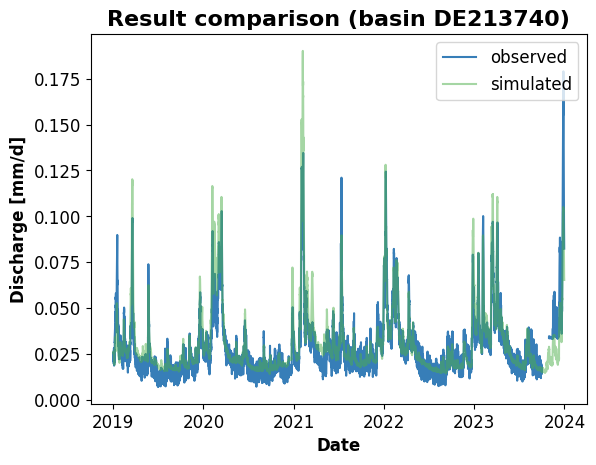

In [6]:
# colorblind friendly palette
color_palette = {"observed": "#377eb8", "simulated": "#4daf4a"}

# # (1) Output time window of test dataset period
plt.plot(test_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(test_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# # (2) Output custom time window
# start_date = "2021-04-01 01:00:00"
# end_date = "2021-04-07 01:00:00"
# plt.plot(test_results[basin_to_analyze]["y_obs"][start_date:end_date], label="observed", color=color_palette["observed"])
# plt.plot(test_results[basin_to_analyze]["y_sim"][start_date:end_date], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title(f"Result comparison (basin {basin_to_analyze})", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right", fontsize=12)
# plt.savefig(os.path.join(test_result_save_path, f"Result comparison (basin {basin_to_analyze}).png"), bbox_inches="tight", pad_inches=0)

### 2.3 Draw hydrograph: rainfall and discharge (sim vs. obs)

We can select to show (1) the whole test time period, or (2) a custom time period

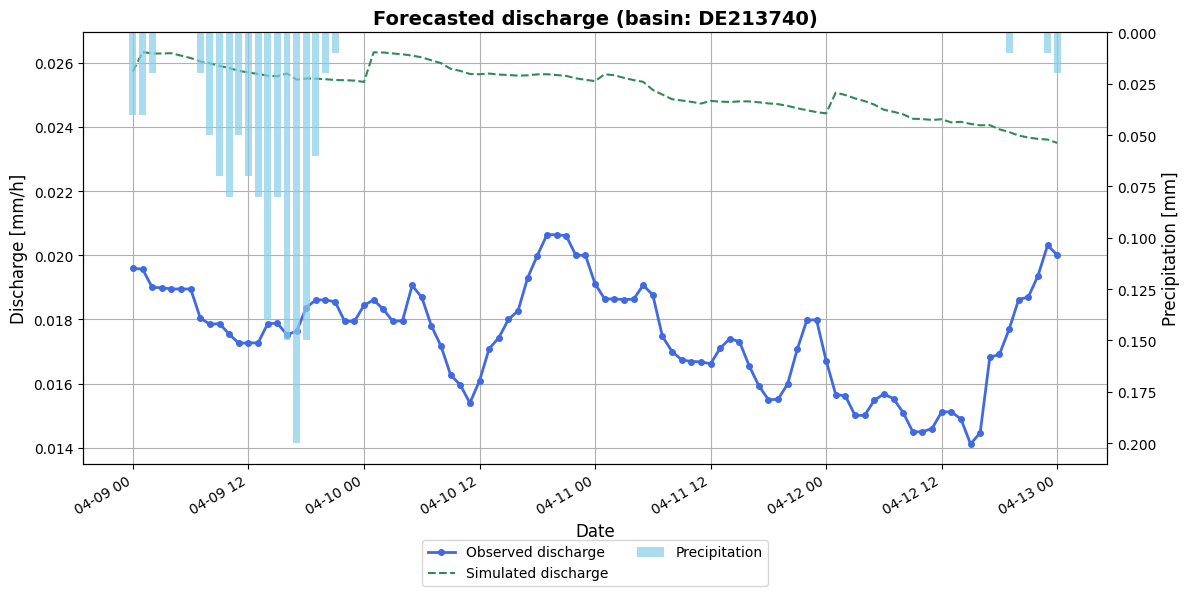

In [7]:
# (1) Output whole time window of test dataset period
# start_date = test_results[basin_to_analyze]["y_obs"].index[0]
# end_date = test_results[basin_to_analyze]["y_obs"].index[-1]
# start_date = pd.to_datetime(start_time)
# end_date = pd.to_datetime(end_time)

# (2) Output custom time window
start_date = "2019-04-09 00:00:00"
end_date = "2019-04-13 00:00:00"

rainfall_df_plot = rainfall_df[(rainfall_df[time_label[0]] >= start_date) & (rainfall_df[time_label[0]] <= end_date)]

# 创建图形和主坐标轴
fig, ax1 = plt.subplots(figsize=(12, 6))

# 设置主坐标轴（径流）
ax1.plot(rainfall_df_plot[time_label[0]], test_results[basin_to_analyze]["y_obs"][start_date:end_date], label='Observed discharge', color='royalblue', linewidth=2, marker='o', markersize=4)
ax1.plot(rainfall_df_plot[time_label[0]], test_results[basin_to_analyze]["y_sim"][start_date:end_date], label='Simulated discharge', color='seagreen', linestyle='--')
ax1.set_ylabel("Discharge [mm/h]", fontsize=12)
ax1.set_xlabel("Date", fontsize=12)
ax1.tick_params(axis='y')
ax1.legend(loc='lower left')
ax1.grid(True)

# 创建次坐标轴（降雨）
ax2 = ax1.twinx()
ax2.bar(rainfall_df_plot[time_label[0]], rainfall_df_plot[target_variables[0]], width=0.03, label='Precipitation', color='skyblue', alpha=0.7)
ax2.set_ylabel("Precipitation [mm]", fontsize=12)
ax2.tick_params(axis='y')
ax2.invert_yaxis()  # 降雨显示在图的上方

# 设置标题
plt.title(f"Forecasted discharge (basin: {basin_to_analyze})", fontsize=14, weight='bold')

# 合并图例
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)

# 自动格式化日期
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

### 3.4 Save rainfall and discharge value (Sim vs. Obs) in a .csv file

In [8]:
# Extract DataFrame
df = test_results[basin_to_analyze].copy()

if isinstance(df.index, pd.DatetimeIndex):
    df.reset_index(inplace=True)
    df.rename(columns={"index": time_label[0]}, inplace=True)

merged_df = pd.merge(df, rainfall_df[[time_label[0], target_variables[0]]],
                     left_on=time_label[0], right_on=time_label[0], how="left")

# # 去掉重复的时间列（若存在）This is Not tested
# if time_label[0] != "date":
#     merged_df.drop(columns=[time_label[0]], inplace=True)

# Save observed and predicted results in Excel files
file_name = f"pred_basin_{basin_to_analyze}.csv"

# Save the predicted flow for each timestep in a csv file
merged_df.to_csv(os.path.join(test_result_save_path,file_name), index=False)

print(f"Data for basin {basin_to_analyze} has been saved to {test_result_save_path}")

Data for basin DE213740 has been saved to D:\Research\Projects\Hy2DL\results\Edu_14_day_seed_110\test_results
